# 두 번째 모델 훈련하기

이 노트북에서 첫 번째 모델의 단점을 극복하기 위한 특성을 사용해 두 번째 모델을 훈련합니다.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import joblib
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')

from ml_editor.data_processing import (
    format_raw_df,
    get_split_by_author,
    train_vectorizer,
    get_vectorized_series,
    get_feature_vector_and_label
)
from ml_editor.model_evaluation import (
    get_feature_importance,
    get_roc_plot,
    get_confusion_matrix_plot,
    get_calibration_plot
)

from ml_editor.model_v2 import (
    add_char_count_features,
    get_word_stats,
    get_sentiment_score,
    POS_NAMES,
    get_question_score_from_input
)
%load_ext autoreload
%autoreload 2
np.random.seed(35)

data_path = Path('data/writers.csv')
df = pd.read_csv(data_path)
df = format_raw_df(df.copy())
df = df.loc[df["is_question"]].copy()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
df["full_text"] = df["Title"].str.cat(df["body_text"], sep=" ", na_rep="")

새로운 모델에 도움이 될만한 후보 특성을 추가합니다.

In [28]:
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

In [29]:
vectorizer = train_vectorizer(train_df)
df["vectors"] = get_vectorized_series(df["full_text"].copy(), vectorizer)

`ml_editor` 소스 코드를 확인하여 이 함수들의 기능을 확인해 보세요!

In [30]:
df = add_char_count_features(df.copy())
df = get_word_stats(df.copy())
df = get_sentiment_score(df.copy())

100%|██████████| 7971/7971 [00:08<00:00, 902.68it/s] 


In [31]:
feature_arr = ["num_questions",
               "num_periods",
               "num_commas",
               "num_exclam",
               "num_quotes",
               "num_colon",
               "num_stops",
               "num_semicolon",
               "num_words",
               "num_chars",
               "num_diff_words",
               "avg_word_len",
               "polarity"
              ]
feature_arr.extend(POS_NAMES.keys())

# 모델

이제 새로운 특성을 추가했으니 새 모델을 훈련해 보죠. 특성만 다르고 이전과 동일한 모델을 사용합니다.

In [32]:
# 특성을 새로 추가했으므로 데이터셋을 다시 나눕니다.
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

In [33]:
X_train, y_train = get_feature_vector_and_label(train_df, feature_arr)
X_test, y_test = get_feature_vector_and_label(test_df, feature_arr)

In [34]:
y_train.value_counts()

Score
False    3483
True     2959
Name: count, dtype: int64

In [35]:
X_test.shape

(1529, 7799)

In [36]:
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', oob_score=True)
clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)
y_predicted_proba = clf.predict_proba(X_test)

Now, we can measure performance as we saw in the first training notebook.

In [37]:
def get_metrics(y_test, y_predicted):
    # 진짜 양성 / (진짜 양성 + 가짜 양성)
    precision = precision_score(y_test, y_predicted, pos_label=True,
                                    average='binary')
    # 진짜 양성 / (진짜 양성 + 가짜 음성)
    recall = recall_score(y_test, y_predicted, pos_label=True,
                              average='binary')

    # 정밀도와 재현율의 조화 평균
    f1 = f1_score(y_test, y_predicted, pos_label=True, average='binary')

    # 진짜 양성 + 진짜 음성 / 전체
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1


# 훈련 정확도
# https://datascience.stackexchange.com/questions/13151/randomforestclassifier-oob-scoring-method 참고
y_train_pred = np.argmax(clf.oob_decision_function_,axis=1)

accuracy, precision, recall, f1 = get_metrics(y_train, y_train_pred)
print("훈련 정확도 = %.3f, 정밀도 = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

훈련 정확도 = 0.602, 정밀도 = 0.582, recall = 0.475, f1 = 0.523


In [38]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
print("검증 정확도 = %.3f, 정밀도 = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

검증 정확도 = 0.621, 정밀도 = 0.633, recall = 0.533, f1 = 0.579


다행히 이 모델은 이전 모델보다 성능이 더 높습니다! 새로운 모델과 벡터화 객체를 나중에 사용하기 위해 디스크에 저장하겠습니다.

In [39]:
model_path = Path("models/model_2.pkl")
vectorizer_path = Path("models/vectorizer_2.pkl")
joblib.dump(clf, model_path)
joblib.dump(vectorizer, vectorizer_path)

['models/vectorizer_2.pkl']

## 특성의 유용성 검증하기

그다음 특성 중요도 [노트북](https://github.com/rickiepark/ml-powered-applications/blob/master/notebooks/feature_importance.ipynb)에서 설명한 방법을 사용해 새로운 특성을 새로운 모델이 사용하는지 확인해 보겠습니다.

In [40]:
# w_indices = vectorizer.get_feature_names()
w_indices = vectorizer.get_feature_names_out()
# w_indices.extend(feature_arr)
w_indices = np.concatenate((w_indices, feature_arr))
all_feature_names = np.array(w_indices)

In [41]:
clf.feature_importances_

array([1.20658265e-05, 3.62850910e-04, 4.27962239e-07, ...,
       2.49887390e-03, 5.43797583e-03, 1.74799920e-03])

In [42]:
k = 20
print("상위 %s개 중요도:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[:k]]))

print("\n하위 %s개 중요도:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[-k:]]))

상위 20개 중요도:

num_diff_words: 0.0087
num_chars: 0.0081
num_periods: 0.0075
num_commas: 0.0072
ADJ: 0.0072
num_questions: 0.007
AUX: 0.007
ADV: 0.0069
num_words: 0.0065
DET: 0.0064
PUNCT: 0.0064
ADP: 0.0063
NOUN: 0.0062
SCONJ: 0.0061
PART: 0.0061
avg_word_len: 0.006
PRON: 0.006
num_stops: 0.0055
VERB: 0.0054
polarity: 0.005

하위 20개 중요도:

um: 0
backyard: 0
defamatory: 0
backing: 0
backgrounds: 0
signify: 0
electronically: 0
practiced: 0
bachelor: 0
roof: 0
babies: 0
silently: 0
deeds: 0
producer: 0
deduce: 0
uncovered: 0
avoids: 0
inch: 0
elite: 0
overlooked: 0


새로운 특성이 가장 예측 성능이 좋은 편이군요! 반대로 TF-IDF 벡터화로 얻은 단어 벡터는 특별히 도움이 되는 것 같지 않습니다. 이어지는 [노트북](https://github.com/rickiepark/ml-powered-applications/blob/master/notebooks/third_model.ipynb)에서 이런 특성을 제외하고 세 번째 모델을 훈련하여 어떤 성능을 내는지 확인해 보습니다.

## 예측과 데이터 비교하기

이 섹션은 새로운 모델로 데이터와 예측 비교하기 [노트북](https://github.com/rickiepark/ml-powered-applications/blob/master/notebooks/comparing_data_to_predictions.ipynb)에서 설명한 평가 방법을 사용합니다.

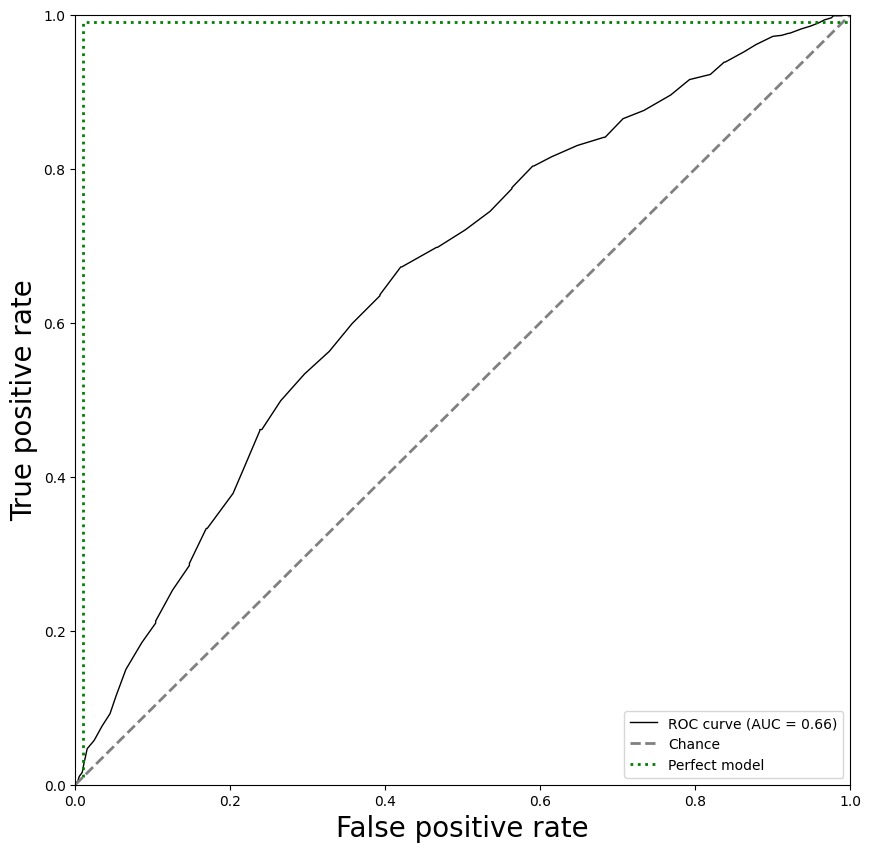

In [43]:
get_roc_plot(y_predicted_proba[:,1], y_test, figsize=(10,10))

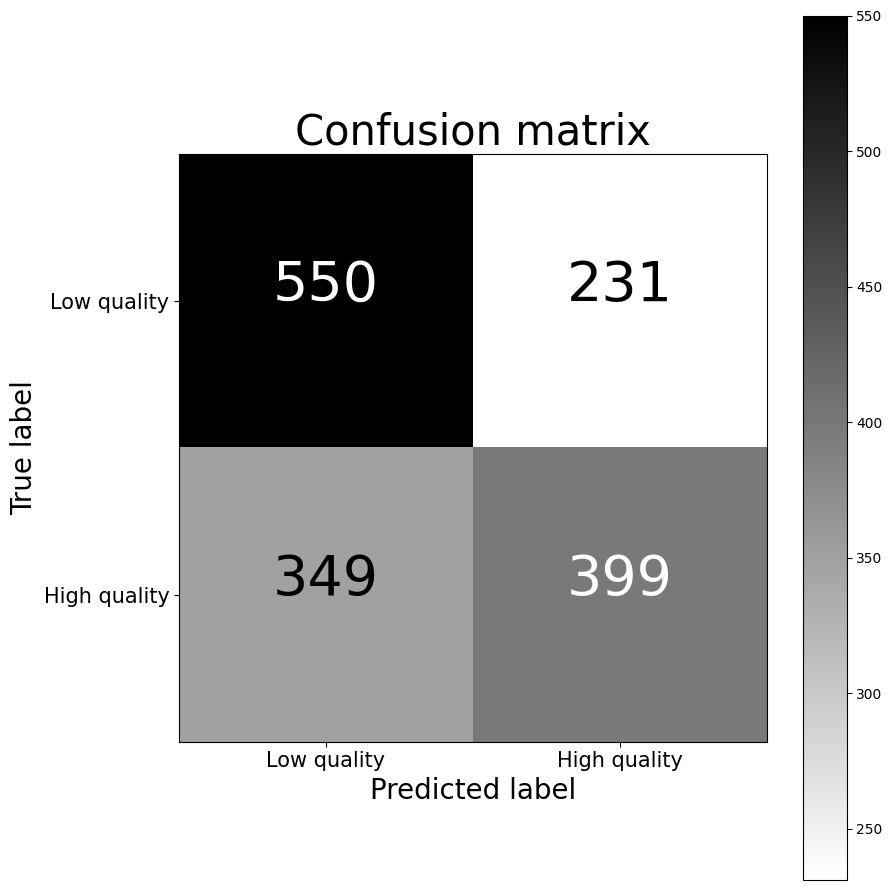

In [44]:
get_confusion_matrix_plot(y_predicted, y_test, figsize=(9, 9))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


	Brier: 0.233


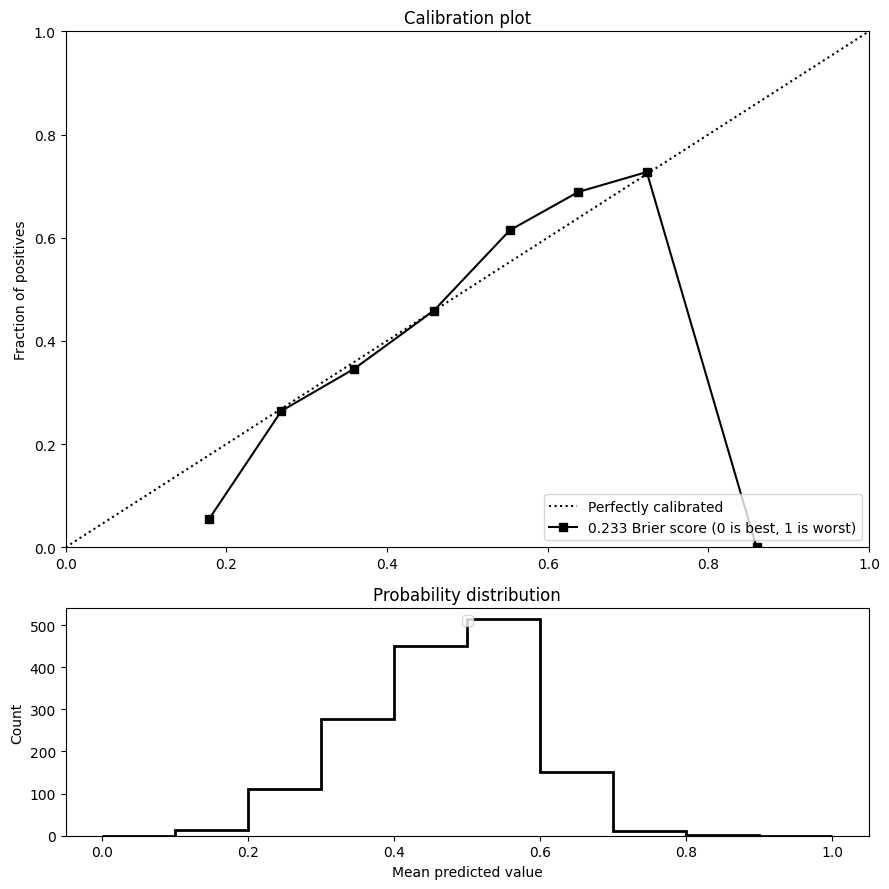

In [45]:
get_calibration_plot(y_predicted_proba[:,1], y_test, figsize=(9,9))

## 추론 함수

첫 번째 모델과 마찬가지로 임의의 질문을 받고 높은 점수를 받을 추정 확률을 출력하는 추론 함수를 정의합니다.

In [46]:
pos_prob = get_question_score_from_input("""
When quoting a person's informal speech, how much liberty do you have to make changes to what they say?
""")

print("%s probability of the question receiving a high score according to our model" % (pos_prob))

100%|██████████| 1/1 [00:00<00:00, 1492.63it/s]

0.44 probability of the question receiving a high score according to our model
